# Multirotor Dynamics in Archimedes

<!-- Brief overview of Archimedes and its relationship to CasADi -->
Archimedes is an open-source Python framework designed to simplify complex modeling and simulation tasks. By leveraging the power of CasADi, a symbolic framework for automatic differentiation and numerical optimization, Archimedes allows engineers and researchers to implement complex models using familiar NumPy syntax while gaining significant performance improvements and advanced capabilities.

Multirotor flight vehicles are a rapidly growing domain of aerospace engineering, boasting applications ranging from photography and package delivery using smaller drones to passenger transport with larger eVTOL concepts.
At the same time, the dynamics of these aircraft are notoriously complex, creating challenges in modeling, design, and control.

The tightly coupled, strongly nonlinear dynamics, unsteady and often extreme aerodynamic conditions, and sensitive dependence on geometry create opportunities for advanced model-based engineering approaches. These include parameter estimation, trajectory optimization, and integrated design optimization.

#### Tutorial overview

In this tutorial, we will walk through the process of modeling a multirotor vehicle using Archimedes. We'll start with a simplified approximation of the aerodynamics and progressively build towards a higher-fidelity blade-element model. This approach will showcase how Archimedes allows us to:

- **Implement models using familiar NumPy code**: We'll write our numerical implementation in standard NumPy, then execute it using the powerful CasADi symbolic/numeric C++ framework.
- **Achieve significant performance gains**: Archimedes can reach 5-10x speedups in simulation compared to vanilla NumPy implementations.
- **Leverage automatic differentiation**: This enables efficient optimization and control design.
- **Generate C code**: For deployment to embedded controllers or other performance-critical applications.
- **Develop modular, extensible models**: We'll use modern software design practices to create a flexible modeling framework.

<!-- Goals of the tutorial -->
This tutorial will cover the following topics:


This tutorial will cover the following topics:

1. **Fundamentals of multirotor dynamics**: 
   - 6-DOF rigid body dynamics
   - Rotorcraft aerodynamics
   - Blade-element momentum theory

2. **Implementation in Archimedes**: 
   - Designing a modular multirotor modeling framework
   - Adapting NumPy code to work with Archimedes

3. **Running the model**:
   - Simulating with a standard SciPy solver
   - Accelerating simulation with Archimedes

3. **Linear systems analysis**: 
   - Efficient trim point identification
   - Linear stability analysis

4. **Blade-element momentum theory**: 
   - Extending the initial model with a more accurate rotor dynamics model

5. **Preview of advanced applications**: 
   - Parameter estimation
   - Trajectory optimization
   - Design space exploration
   - Advanced aerodynamics modeling

#### Prerequisites

While this tutorial aims to be largely self-contained, it will reference established texts for detailed presentations of modeling methods, focusing instead on implementation and applications with Archimedes. A basic familiarity with rigid body dynamics and aerodynamics will be helpful. We'll closely follow the notation and methods from these references:

* "Principles of Helicopter Aerodynamics" by Leishman
* "Aircraft Control and Simulation" by Stevens, Lewis, and Johnson
* "Flight Dynamics" by Stengel
* ["Development and application of a medium-fidelity analysis code for multicopter aerodynamics and flight dynamics"](https://dspace.rpi.edu/items/14f1cb03-4c62-4365-a389-c70de7afb442) by Niemiec

Some basic Python knowledge will also be beneficial. Our code makes extensive use of:
- [Dataclasses](https://realpython.com/python-data-classes/)
- [Composition and inheritance](https://realpython.com/inheritance-composition-python/)
- [Callable objects](https://realpython.com/python-callable-instances/)

To run the code, you'll need a Python environment configured with Archimedes and its dependencies (NumPy, SciPy, Matplotlib, and CasADi).


In [1]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.optimize import root

import archimedes as arc
import multirotor

np.set_printoptions(precision=3, suppress=True)

## 1. Fundamentals of multirotor dynamics

Before we get into more accurate aerodynamics modeling, it's easiest to start with the basic kinematic equations and a highly simplified dynamics model.  Then we can develop our modeling framework with a view towards extensibility.

#### 6-dof rigid body dynamics

Let's start with the basics of rigid body dynamics.  Our goal is to develop a set of equations that will fully determine the evolution of a rigid body if we know the applied forces and moments.  To do so we will work primarily with two reference frames:

* The "world" frame: an inertial or Newtonian frame denoted N, in which the $x$-$y$-$z$ axes are defined with the North-East-Down (NED) convention
* The "body" frame: a non-inertial body-fixed reference frame denoted B whose origin is at the body center of mass and with axes defined according to the Forward-Right-Down (FRD) convention

The position of the center of mass of the vehicle in the "world" frame is $\mathbf{p}_N$ (and clearly the body-relative position is always $\mathbf{p}_B = 0$).  For the sake of simplicity we will represent orientation using Euler angles in the yaw-pitch-roll sequence, i.e. the transformation from the world frame to the body frame takes place as a sequence of three rotations:

1. Right-handed rotation about the world-frame $\hat{z}$ axis by the yaw angle $\psi$
2. Right-handed rotation about the _new_ $\hat{y}$ axis by the pitch angle $\theta$
3. Right-handed rotation about the _new_ $\hat{x}$ axis by the roll angle $\phi$

From these three Euler angles $(\phi, \theta, \psi)$ we can construct the $3 \times 3$ rotation matrix $~^B\!\mathbf{C}^N(\phi, \theta, \psi)$, which relates any vector $\mathbf{p}_N$ expressed world-frame coordinates to the same vector in body-frame coordinates according to the relations

$$
\begin{align*}
\mathbf{p}_B &= ~^B\!\mathbf{C}^N \mathbf{p}_N \\
\mathbf{p}_N &= ~^N\!\mathbf{C}^B \mathbf{p}_B = [~^B\!C^N]^T \mathbf{p}_B.
\end{align*}
$$

That is, the rotation matrix $~^B\!\mathbf{C}^N$ satisfies the orthogonal matrix property that the inverse transformation is $~^N\!\mathbf{C}^B = [~^B\!\mathbf{C}^N]^{-1} = [~^B\!\mathbf{C}^N]^T$.

The combination of the position $\mathbf{p}_N$ with the Euler angles $\mathbf{\Phi} = \begin{bmatrix} \phi & \theta & \psi \end{bmatrix}^T$ comprises the six "degrees of freedom" of the rigid body.
However, to fully specify the state of the system we also need to know the velocity and angular velocity of the body.  It is generally more convenient to work with these quantities in the body-fixed reference frame even though this frame is non-inertial, for instance because this means that the inertia matrix does not vary in time (unless the weight or mass distribution changes, which we will not consider here).  Defining the body-frame velocity $\mathbf{v}_B$ and angular velocity $\mathbf{\omega}_B$, the full state has 12 elements:

$$
\mathbf{x} = \begin{bmatrix} \mathbf{p}_N & \mathbf{\Phi} & \mathbf{v}_B & \mathbf{\omega}_B \end{bmatrix}^T.
$$

#### Kinematic relations

The evolution equations for this state are complicated by two factors.  First, the velocities and positions are expressed in different reference frames, so for instance it is not the case that $\dot{\mathbf{p}}_N = \mathbf{v}_B$.  Second, the Euler angles do not make up a vector and _the time derivatives of the Euler angles are not equal to the angular velocity in any reference frame._
Instead, the two are related according to the "Euler kinematical equations", derived for instance in Sec 1.4 of Stevens, Lewis, and Johnson.

$$
\dot{\mathbf{\Phi}} = \begin{bmatrix}
1 & \sin \phi \tan \theta & \cos \phi \tan \theta \\
0 & \cos \phi & -\sin \phi \\
0 & \sin \phi / \cos \theta & \cos \phi / \cos \theta
\end{bmatrix}
\mathbf{\omega}_B \equiv H(\phi, \theta) \mathbf{\omega}_B
$$

Note that the matrix $H(\phi, \theta)$ becomes singular at $\pm 90$ degrees pitch, leading to the issue known as "gimbal lock".
As a result quaternion representations of rotations are generally preferable, but here we will use Euler angles for the sake of simplicity and interpretability and remember to avoid overly aggressive maneuvers.

The time derivative of world-frame position, on the other hand, is just related to the body-frame velocity by the rotation matrix:

$$
\dot{\mathbf{p}}_N = ~^N\!\mathbf{C}^B \mathbf{v}_B.
$$

Finally, since the velocity and angular velocity are expressed in the non-inertial body frame, Newton's laws have to be augmented with "pseudo" forces and moments, which we will give here without derivation:

$$
\begin{align*}
\dot{\mathbf{v}}_B &= \frac{1}{m} \mathbf{F}_B - \mathbf{\omega}_B \times \mathbf{v}_B \\
\dot{\mathbf{\omega}}_B &= J_B^{-1} \left[ \mathbf{M}_B - \mathbf{\omega}_B \times J_B \times \mathbf{\omega}_B \right],
\end{align*}
$$

in which $m$ is the mass of the body, $J_B$ is its inertia matrix, and $\mathbf{F}_B$ and $\mathbf{M}_B$ are the net body-referenced force and moment, respectively.  Remember that gravity is typically most easily defined in the _world_ frame, and so must be rotated into the body frame before its contribution is added to the net force.  This set of four vector equations fully defines the 6-dof rigid body equations of motion for a flight vehicle, although they will not hold in all cases, for instance if:

* The distances considered are long enough that the curvature of the Earth is significant
* The mass or inertia matrix of the body is time-varying
* The body cannot be considered a single rigid object, for instance if the motion of flight control surfaces cannot be safely neglected.

#### Simplified dynamics model

The preceding derivation is fairly general, and could be adapted to helicopters, drones, fixed-wing aircraft, missiles, etc.
The dynamics of these vehicles are distinguished by the forces and moments to which they are subject, and by the effect of external controls.

In our multirotor model we will primarily consider three sources of external influence:

1. __Gravity:__ Modeled as a constant force $m g_0$ in the inertial-frame $\hat{z}$-direction
2. __Drag:__ A single force applied at the center of pressure of the vehicle $\mathbf{r}_B^{CoP}$, generally dependent on the airspeed of the vehicle and its orientation with respect to this "wind"
3. __Rotors:__ A force and moment produced by each rotor, in general dependent on aerodynamics and rotor speeds

The net force in the body frame

$$
\mathbf{F}_B^\mathrm{net} = \mathbf{F}_B^D + \sum_{j=1}^{N} \mathbf{F}_B^j + ^BC^N \mathbf{F}_N^g,
$$

where $\mathbf{F}_B^D$ is the drag force, $\mathbf{F}_N^g$ is the inertial-frame gravity force, and $\mathbf{F}_B^j$ is the force from the $j$-th rotor.

The net moment in the body frame contains only contributions from drag (if the center of pressure is not collocated with the center of mass) and the rotors.  The rotor contributions 

$$
\mathbf{M}_B^\mathrm{net} = \mathbf{r}_B^{CoP} \times \mathbf{F}_B^D + \sum_{j=1}^N \left( 
\mathbf{M}_H^j + \mathbf{r}_B^j \times \mathbf{F}_B^j,
\right)
$$

where $\mathbf{M}_B^j$ are the moments due to the $j$-th rotor motion (e.g. torque) and $\mathbf{r}_B^j$ is the offset of the center of the $j$-th rotor (the lever arm).

Later we will introduce additional "hub" reference frames to model the rotor dynamics in more detail, but at this stage we will use simple models that can easily be written in body-fixed coordinates.

For the drag force, we will neglect any variability with respect to angle of attack or sideslip angle and assume that the body drag force can be written in terms of the air density $\rho$, characteristic cross-sectional area $A$, and dimensionless drag coefficient $C_D$ by

$$
\mathbf{F}_B^D = -\frac{1}{2} \rho C_D A ||\mathbf{v}_B|| \mathbf{v}_B
$$

A simplified rotor model assumes a quadratic dependence on rotor angular velocity.  That is, if $\Omega_j$ is the angular velocity of the $j$-th rotor in rad/s and $H_j$ is a reference frame attached to the $j$-th rotor hub, we will assume that

$$
\begin{align*}
\mathbf{F}_{H_j}^j &= -k_F \Omega_j^2 \hat{\mathbf{z}} \\
\mathbf{M}_{H_j}^j &= k_M \Omega_j^2 \hat{\mathbf{z}},
\end{align*}
$$

where $k_F$ and $k_M$ are force and moment coefficients, and we assume that each is purely in the _hub_-frame $z$-direction.
The sign of the moment will also be flipped if the rotor is spinning clockwise.
The reference frames are summarized in the following figure:

<img src="img/frames1.png" alt="reference_frames1" width="600"/>

The center of the rotor hub is offset from the body center of mass by $\mathbf{r}_B^j$, and we define the $x$-$y$ plane of the hub frame to be in the rotor plane with the $z$-axis pointing opposite to the direction of nominal thrust (i.e. downward).
This may be inclined with respect to the body-frame $x$-$y$ plane if the rotor has a static "cant", in which case there will be a constant rotation matrix $ ~^B\!\mathbf{C}^{H_j}$ that transforms from the $j$-th hub frame to the body frame.
The force and moment in the body frame are then

$$
\begin{align*}
\mathbf{F}_B^j &= ~^B\!\mathbf{C}^{H_j} \mathbf{F}_{H_j}^j \\
\mathbf{M}_B^j &= ~^B\!\mathbf{C}^{H_j} \mathbf{M}_{H_j}^j + \mathbf{r}_B^j \times \mathbf{F}_B^j,
\end{align*}
$$

This rotor model will tend to be approximately correct near hover, but will generally be too simplistic to properly predict the rotor loads in other maneuvers.
Later we will revisit the rotor model, but for the time being this set of equations is enough to build a full multirotor dynamics model.



## 2. Implementation in Archimedes

Now that we have a set of equations defining our basic multirotor vehicle model, we can start thinking about implementation.
The basic task here is to construct a function $\dot{\mathbf{x}} = \mathbf{f}(t, \mathbf{x}, \mathbf{u})$ that we can use to simulate the model, where $\mathbf{x}$ is the 12-element state vector defined above and $\mathbf{u}$ is the $N_r$-element vector of rotor angular velocities (e.g. $N_r = 4$ for a quadcopter).
Without loss of generality, we can require that the inputs $\mathbf{u}$ be defined as a function of time and state, so that the system can be expressed in the self-contained form $\dot{\mathbf{x}} = \mathbf{f}(t, \mathbf{x})$.

As a side note, for the sake of simplicity we are assuming that the angular velocities are directly given as inputs.
A more complete model might also include motor dynamics, etc. and include more than 12 elements in the state vector.
The state vector can also have additional elements related to the aerodynamics model, representing for instance the locations of point vortices or other reduced representations of the flow field.
These can be represented in the same $\dot{\mathbf{x}} = \mathbf{f}(t, \mathbf{x})$ form by augmenting the state vector and dynamics function appropriately.

The most basic approach to constructing such a model is to write a function with this signature that implements the entire model:

```python
import numpy as np

def f(t, x):
    """Monolithic model implementation
    
    Assumes separate functions `dcm`, `u`, `net_forces`, and `euler_kinematics`"""
    p_N = x[0:3]  # Position of the center of mass in the Newtonian frame N (unused here)
    rpy = x[3:6]  # Roll-pitch-yaw Euler angles
    v_B = x[6:9]  # Velocity of the center of mass in body frame B
    w_B = x[9:12] # Roll-pitch-yaw rates in body frame (ω_B)

    # Convert roll-pitch-yaw (rpy) orientation to the direction cosine matrix.
    C_BN = dcm(rpy)

    F_B, M_B = net_forces(t, x, u(t, x), C_BN)

    # Transform roll-pitch-yaw rates in the body frame to time derivatives of Euler angles
    # These are the Euler kinematic equations (1.4-5)
    H = euler_kinematics(rpy)

    # Time derivatives of roll-pitch-yaw (rpy) orientation
    drpy = H @ w_B

    # Velocity in the Newtonian frame
    dp_N = C_BN.T @ v_B

    # Acceleration in body frame
    dv_B = (F_B / m) - np.cross(w_B, v_B)

    # Angular acceleration in body frame
    # solve Euler dynamics equation 𝛕 = I α + ω × (I ω)  for α
    dw_B = J_B_inv @ (M_B - np.cross(w_B, J_B @ w_B))

    # Pack the state derivatives
    return np.hstack([dp_N, drpy, dv_B, dw_B, aux_state_derivs])
```

In Archimedes, this implementation can use standard NumPy functions, which are then "traced" symbolically to construct the CasADi computational graph.
This way, it is easy to switch back and forth between vanilla NumPy for development and debugging and Archimedes/CasADi for performance, automatic differentiation, or C code generation.

Although this implementation is straightforward, it is fairly limiting in that changing the models for gravity, vehicle aerodynamics, rotor aerodynamics, etc. requires rewriting the function.
Here we will pursue an alternative design using Python classes to construct a modular and composable modeling framework.
In short, we will create a set of callable classes that implement well-defined interfaces; then we can construct customized dynamics models by treating these as swappable components.

#### Composable functors

In the lingo of object-oriented programming, a "functor" is an object that can be called like a function.
In Python this can be accomplished by implementing the `__call__` method for a class, which allows it to be called with function syntax.
Combining this with the `struct.pytree_node` concept gives us a simple and powerful pattern for organizing our parameters and functional behavior.
For instance, we can rewrite the 6-dof dynamics function above as follows:

```python
import numpy as np
from archimedes import struct

@struct.pytree_node
class FlightVehicle:
    """Callable dataclass implementation"""
    m: float  # Vehicle mass
    J_B: np.ndarray  # Vehicle inertia matrix in body-frame coordinates

    def __call__(self, t, x):
        """6-dof dynamics implementation
        
        Still assumes separate functions `dcm`, `u`, `net_forces`, and `euler_kinematics`"""
        # Same as above, except now we can use `self.m`, `self.J_B`, etc
```

While we will use this callable pattern for other components in our model, for consistency with [recommended design patterns in Archimedes](LINK), we will actually use the name `dynamics` to implement the ODE right-hand side calculation.

At first, it doesn't look like we've gained much with this approach.
Along with external utility functions `dcm` and `euler_kinematics`, we still rely on separately defined functions to compute the inputs and net forces.
We could amend the class definition by making `net_forces` a method of this class.
Since the 6-dof dynamics are generic, but the multirotor forces are much more specific to this particular flight vehicle, it makes sense to define this method as _abstract_:

```python
import abc
import numpy as np
from archimedes import struct

@struct.pytree_node
class FlightVehicle(metaclass=abc.ABCMeta):
    """Callable dataclass implementation"""
    m: float  # Vehicle mass
    J_B: np.ndarray  # Vehicle inertia matrix in body-frame coordinates

    @abc.abstractmethod
    def net_forces(self, t, x, u, C_BN):
        """Net forces and moments in body frame B"""
        # Empty for abstract base class

    def dynamics(self, t, x):
        """6-dof dynamics implementation"""
        # ...
```

This will throw an error if we try to instantiate a `FlightVehicle` as is, since we haven't implemented the `net_forces` method.
We still have to specialize this to the multirotor by summing contributions from gravity, drag, and each of the rotors:

```python
@struct.pytree_node
class MultiRotorVehicle(FlightVehicle):

    def net_forces(self, t, x, u, C_BN):
        # Sum forces due to gravity, body aerodynamics, and rotors
        # ...
```

If we wanted to, we could add a second class for a fixed-wing vehicle that replaced the rotor models with engines, added flight control surfaces, and so on.
We could also add a third class for a satellite that implemented appropriate reference frame transformations, thruster models, etc.
Each of these would reuse the generic part of the code that deals with 6-dof kinematics, implemented in the base class `FlightVehicle`.
This approach is _inheritance_.

However, this still leaves us with a problem.
We have several different pieces of our model that might independently be swapped out.
For instance, we could independently vary the models for gravity, vehicle aerodynamics, and rotor aerodynamics.
Each combination of these would require a new implementation of `net_forces`, leading to a combinatorial explosion of `MultiRotorVehicle` subclasses.

This is where _composition_ comes in.
For each of these component models (gravity, vehicle aerodynamics, rotor aerodynamics) we will define an abstract interface and a limited set of concrete implementations.

#### Modular models

As a tangible example, let's say we want to explore the effect of switching between a uniform gravity model $F_N^g = m g_0 \hat{\mathbf{z}}_N$ and an $r^{-2}$ point-mass gravity model that depends on the position relative to the Earth's center of mass.

In the general case the acceleration due to gravity depends on the position of the body in the inertial frame N, although not its velocity or orientation.
With that in mind, we can define a generic callable interface for gravity, with specific implementations for each of our models:

```python
@struct.pytree_node
class GravityModel(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def __call__(self, p_N):
        """Gravitational acceleration at the body CM in the inertial frame N

        Args:
            p_N: position vector in inertial frame N

        Returns:
            g_N: gravitational acceleration in inertial frame N
        """


@struct.pytree_node
class ConstantGravityModel(GravityModel):
    g0: float = 9.81

    def __call__(self, p_N):
        return np.array([0, 0, self.g0], like=p_N)


@struct.pytree_node
class PointGravityModel(GravityModel):
    r_EN: np.ndarray  # Position vector from Earth's CM to the origin of the N frame [m]
    G: float = 6.6743e-11  # Gravitational constant [N-m²/kg²]

    def __call__(self, p_N):
        # ...
```

We could also include an oblate-Earth model, lookup tables based on measured gravity, etc.

With this clearly-defined interface, we can add a gravity model to the `MultiRotorVehicle` and reliably access it as follows:

```python
@struct.pytree_node
class MultiRotorVehicle(FlightVehicle):
    gravity_model: GravityModel

    def net_forces(self, t, x, u, C_BN):
        # Sum forces due to gravity, body aerodynamics, and rotors
        p_N = x[:3]  # Location of body CM in N-frame coordinates
        Fgravity_N = self.m * self.gravity_model(p_N)
        # ...
```

Now we can customize our gravity model outside of the vehicle dynamics, allowing us to swap models without modifying the code:

```python
g0 = 9.81
m = 2.0
J_B = np.diag([0.01, 0.02, 0.03])
gravity = ConstantGravityModel(g0=g0)
vehicle = MultiRotorVehicle(m=m, J_B=J_B, gravity_model=gravity)
```

For our purposes, a constant gravity model will likely not be the limiting factor on the model accuracy, but it illustrates the basic idea.
In the implementation used below, we ultimately have three abstract model interfaces: `RotorModel`, `VehicleDragModel`, and `GravityModel`.
The `VehicleDragModel` simply computes drag forces and moments, while the `RotorModel` is responsible for computing forces and moments due to a single rotor.
The rotor model is called repeatedly for each of the rotors.
This requires knowing the position and orientation of the rotor disk with respect to the body center of mass, for which we introduce a "hub frame" $H_j$ for each of the $N_r$ rotors.
To help manage this we also introduce a fourth "pure" dataclass, `RotorGeometry`.
All told, our basic class structure looks like this:

```python
import abc
import numpy as np
from archimedes import struct


@struct.pytree_node
class FlightVehicle(metaclass=abc.ABCMeta):
    """Callable dataclass implementation"""
    m: float  # Vehicle mass
    J_B: np.ndarray  # Vehicle inertia matrix in body-frame coordinates

    @abc.abstractmethod
    def net_forces(self, t, x, u, C_BN):
        """Net forces and moments in body frame B"""
        # Empty for abstract base class

    def dynamics(self, t, x):
        """6-dof dynamics implementation"""
        # ...


@struct.pytree_node
class RotorGeometry:
    offset: np.ndarray = struct.field(default_factory=lambda: np.zeros(3))  # Location of the rotor hub in the body frame B [m]
    ccw: bool = True  # True if rotor spins counter-clockwise when viewed from above
    torsional_cant: float = 0.0  # torsional cant angle χ [rad]
    flapwise_cant: float = 0.0  # flapwise cant angle γ [rad]

    @cached_property
    def R_BH(self):
        """Rotation matrix from the hub frame H to the body frame B"""
        # ...
    
    @property
    def r_B(self):
        """Offset of the rotor hub in the body frame coordinates B"""
        return self.offset
    
    def __hash__(self):
        # To use this as a "static arg" in Archimedes it has to be hashable
        return hash((str(self.offset), self.ccw, self.torsional_cant, self.flapwise_cant))


class VehicleDragModel(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def __call__(self, t, x):
        """Drag forces and moments in body frame B

        Args:
            t: time
            x: state vector

        Returns:
            F_B: drag forces in body frame B
            M_B: drag moments in body frame B
        """


class GravityModel(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def __call__(self, p_N):
        """Gravitational acceleration at the body CM in the inertial frame N

        Args:
            p_N: position vector in inertial frame N

        Returns:
            g_N: gravitational acceleration in inertial frame N
        """


class RotorModel(metaclass=abc.ABCMeta):
    def __call__(self, t, v_B, w_B, x, u, geometry: RotorGeometry):
        """Aerodynamic forces and moments in body frame B

        Args:
            t: time
            v_B: velocity of the center of mass in body frame B
            w_B: angular velocity in body frame B
            x: state vector
            u: rotor speed
            geometry: rotor geometry

        Returns:
            F_B: aerodynamic forces for this rotor in body frame B
            M_B: aerodynamic moments for this rotor in body frame B
        """
        # Call self.wind_frame_loads to get F_W and M_W
        # Then translate to hub frame H (defined by `geometry`)
        # and finally return body frame 
        # ...

    @abc.abstractmethod
    def wind_frame_loads(self, t, v_W, w_W, x, u, geometry):
        """Aerodynamic forces and moments in wind frame W"""


@struct.pytree_node
class MultiRotorVehicle(FlightVehicle):
    rotors: list[RotorGeometry]
    rotor_model: RotorModel
    drag_model: VehicleDragModel
    gravity_model: GravityModel

    def net_forces(self, t, x, u, C_BN):
        # Sum forces due to gravity, body aerodynamics, and rotors
        # ...
```

See the source code for the specific implementations of the code snipped with ellipses comments. 
For the basic dynamics model described above, we will also have concrete implementations of `VehicleDragModel`, `GravityModel`, and `RotorModel`:

```python
@struct.pytree_node
class QuadraticDragModel(VehicleDragModel):
    """Simple velocity-squared drag model for the main vehicle body"""
    rho: float = 1.225  # air density [kg/m^3]
    Cd: float = 0.0  # drag coefficient
    A: float = 1.0  # reference planform area [m^2]
    r_CoP = np.zeros(3)  # Center of pressure offset from body CG [m]

    def __call__(self, t, x):
        v_B = x[6:9]  # Velocity of the center of mass in body frame B

        # Velocity magnitude with guard against near-zero values
        v_mag = np.linalg.norm(v_B)
        v_mag = np.where(v_mag < 1e-6, 1e-6, v_mag)

        # Drag force in body frame (3-element vector)
        D_B = -0.5 * self.rho * self.Cd * self.A * v_mag * v_B

        # Drag moment in body frame (3-element vector)
        M_B = np.cross(self.r_CoP, D_B)

        return D_B, M_B


@struct.pytree_node
class ConstantGravityModel(GravityModel):
    """Uniform gravitational field (flat-Earth approximation)"""
    g0: float = 9.81

    def __call__(self, p_N):
        return np.array([0, 0, self.g0], like=p_N)


@struct.pytree_node
class QuadraticRotorModel(RotorModel):
    """Velocity-squared model for rotor aerodynamics"""
    kF: float = 1.0  # aerodynamic force constant [N/rad^2]
    kM: float = 0.0245  # aerodynamic torque constant [N*m/rad^2]

    num_states: ClassVar[int] = 0

    def wind_frame_loads(self, t, v_W, w_W, x, u, geometry: RotorGeometry):
        M_sign = 1 if geometry.ccw else -1
        z_W = np.array([0., 0., 1.])
        u_sq = u * u

        # Note that the wind and hub frame z-axes are coincident
        F_W = -self.kF * u_sq * z_W
        M_W = M_sign * self.kM * u_sq * z_W

        return F_W, M_W
```

The full class hierarchy is summarized graphically below:

<img src="img/class_hierarchy.png" alt="class_hierarchy" width="400"/>

While we don't expect to need any other gravity models, it is certainly possible that replacing the vehicle drag model with one that accounts for angle of attack and sideslip angle would improve the accuracy of the model.
In this tutorial, however, we will primarily focus on improving the rotor model; the additional model components are included to illustrate the approach to constructing a modeling framework by using the programming principles of abstraction, inheritance, and composition.

#### Composition vs. Inheritance

We now have a flexible, modular, and extensible framework for 6-dof vehicle dynamics modeling.
In essence, we have defined a set of "building blocks" from which we construct our main dynamics model $\dot{\mathbf{x}} = \mathbf{f}(t, \mathbf{x}, \mathbf{u})$ (in code: `FlightVehicle.dynamics(t, x, u)`).
We have used two principal concepts to design this framework: composition (a primary class that "owns" several components with well-defined interfaces) and inheritance (a base class and subclasses).
A key question is: when do you prefer composition and when do you choose inheritance?

A commonly quoted design pattern is to "prefer composition over inheritance" based on the idea that inheritance will lead to the combinatorial explosion of subclasses: `MultiRotorWithConstantGravityAndQuadraticDrag`, `MultiRotorWithPointMassGravityAndTabulatedDrag`, etc.

A more precise rule of thumb is to ask whether the base class "X is a Y" or "X has a Y".
The right solution is typically inheritance in the former case and composition in the latter.
In our case, it's easy to plug in the class names to understand the hierarchy:

* `MultiRotorVehicle` _is_ a `FlightVehicle` (inheritance)
* `MultiRotorVehicle` _has_ a `GravityModel` (composition)
* `ConstantGravityModel` _is_ a `GravityModel` (inheritance)

It's worth taking a minute to make sense of the class structure here, since we'll expand it significantly with the blade element momentum theory aerodynamics model (a new `RotorModel` implementation) later in this tutorial.

This is far from the only (or probably even the best way) to construct this kind of modeling framework, but for more complicated models it's almost certainly preferable to the "monolithic" approach we started with.

#### Using Archimedes

You may have noticed that none of our model implementations so far use Archimedes beyond using the `pytree_node` decorator to create composable models.
Still, because we have only used NumPy functions (and have been careful to include `like=x` whenever we call `np.array`), we can evaluate any of these methods symbolically just as easily as we can with numerical arrays.
As we'll see, this makes it easy to develop a model in pure NumPy and then use Archimedes for advanced use cases like accelerated simulation, optimization, stability analysis, and C code generation.

In terms of design, the key thing to remember is to create _pure_ functions (or methods).
A pure function does not modify _anything_, including its inputs; it just computes the output as a function of the inputs.
In general, if you start by writing the mathematical equations and then implementing them as close to the math as possible, the resulting functions will tend to be pure (if for no other reason, since it's just not easy to write "impure math" on paper).

Specifically, we don't want to use preallocated "work" variables to store intermediate results:

```python
@struct.pytree_node
class PureCallable:
    a: float = 1.0

    # OK for symbolic evaluation with Archimedes
    def __call__(self, x):
        y = np.sin(a * x)
        return np.exp(y)

@struct.pytree_node
class ImpureCallable:
    a: float = 1.0
    y: float = 0.0  # Try to save allocations with pre-allocated variable

    # Not OK for symbolic evaluation with Archimedes
    def __call__(self, x):
        self.y = np.sin(a * x)
        return np.exp(self.y)
```

What happens in the latter case is that Archimedes will feed a `SymbolicArray` object to `ImpureCallable.__call__`, which will then _store_ the `SymbolicArray` resulting from the sine function in `self.y`.
While this might actually work in this case, you will get stray symbolic objects in unexpected places which can cause all kinds of unexpected problems.
Basically, behavior for impure functions and callable classes is not well-defined and these should be avoided at all costs.
In fact, by default the `pytree_node` decorator will create a "frozen" class definition, meaning that it will throw an error if you even try to modify one of the object's fields.
This can be overridden, but it's done as a reminder to write pure functions.

This _does_ mean that the most efficient NumPy code you can write will likely look different from code that is compatible with Archimedes, since fast NumPy code will usually use pre-allocated arrays, as with C or FORTRAN codes.
Don't worry, though - the CasADi symbolic system is very efficient and good at figuring this kind of thing out.
As a result, code that looks suboptimal in pure Python can still be very efficient in Archimedes

Besides writing pure functions, keep in mind the usual [gotchas](LINK) related to control flow: basically, avoid `while` loops and `if/else` statements depending on variable data (tip: the latter can often be replaced with `np.where`).

#### Build-in `FlightVehicle`

Finally, although we have included `FlightVehicle` as part of our class hierarchy here, there is actually a generic `FlightVehicle` included with Archimedes that implements 6dof dynamics using either Euler angles or (by default) quaternions for attitude representation.
The interface is the same as what we've shown here, and you can look at the source code in `multirotor.py` to see how exactly it builds on the generic `FlightVehicle`.

One difference with what we've shown here is that instead of using a flat 12-element vector to represent the state of the vehicle, the built-in `FlightVehicle` defines its own `State` class.
This is another `pytree_node` with fields for each of the four groups of state variables: position (`State.p_N`), attitude (`State.att`), velocity (`State.v_B`), angular velocity (`State.w_B`), and any additional state variables (`State.aux`).
The naming convention follows [monogram notation](https://drake.mit.edu/doxygen_cxx/group__multibody__notation__basics.html).

This avoids the need to remember what index represents the $y$-component of angular velocity, for example.
It also makes it easier to switch between attitude representations and allows for arbitrary additional state variables in the `aux` field.
For instance, if we have a rotor model that includes unsteady aerodynamics, these states can be defined as more `pytree_node`s and nested inside the `FlightVehicle.State.aux` field.

## 3. Running the model

We've now made it through the hard part; the math for the dynamics model is done, and we've translated it into modular and extensible Python code.
Instantiating the model is a matter of defining the various parameters and then constructing the model components for gravity, vehicle drag, and rotor aerodynamics.

In [2]:
m = 2.0  # Body mass [kg]
R = 0.15  # Rotor radius (also boom length) [m]
H = 0.15  # Body height [m]
L = 0.30  # Rotor arm length [m]
rho = 1.225  # Density of air [kg/m^3]
Cd = 1.6  # Drag coefficient [-]
kF = 1e-5  # Force coefficient for rotors [kg-m]
kM = 1e-7  # Moment coefficient for rotors [kg-m^2]
g0 = 9.81  # Gravitational acceleration [m/s^2]

# Inertia matrix of a cylinder with mass m, radius R, and height h
J_B = np.array([
    [m/12*(3*R**2 + H**2), 0, 0],
    [0, m/12*(3*R**2 + H**2), 0],
    [0, 0, m/2*R**2],
])

# Four rotors mounted at 45, 135, 225, and 315 degrees
# No canting and alternating spin directions
rotors = []
theta = np.pi/4
ccw = True
for i in range(4):
    rotors.append(multirotor.RotorGeometry(
        offset=np.array([L*np.cos(theta), L*np.sin(theta), 0]),
        ccw=ccw,
    ))
    theta += np.pi/2
    ccw = not ccw

# Construct the model components for gravity, vehicle drag, and
# rotor aerodynamics
gravity_model = multirotor.ConstantGravityModel(g0=g0)
drag_model = multirotor.QuadraticDragModel(
    rho=rho, Cd=Cd, A=R*H,
)
rotor_model = multirotor.QuadraticRotorModel(kF=kF, kM=kM)

# Create the complete vehicle model
vehicle = multirotor.MultiRotorVehicle(
    m=m,
    J_B=J_B,
    rotors=rotors,
    drag_model=drag_model,
    rotor_model=rotor_model,
    gravity_model=gravity_model,
    attitude="euler",
)

This gives us an object `vehicle` with the dynamics function `vehicle.dynamics(t, x, u)`, where `u` is expected to be an array of the inputs.

We'll start with a simple simulation using constant angular velocity, at a value chosen to be slightly less than required to hover.
The vehicle will accelerate rapidly until the velocity-squared body drag balances out gravity (i.e. terminal velocity).
Remember that we've defined our vehicle body frame B as "Forward-Right-Down" and our inertial frame N as "North-East-Down", so that positive body-frame velocity and inertial frame position both indicate "down".

In [3]:
t0 = 0.0
t1 = 100.0
t_span = (t0, t1)

u0 = 500.0 * np.ones(4) # Rotor angular velocity

x0 = vehicle.State(
    p_N=np.zeros(3),  # Initial position [m]
    att=np.zeros(3),  # Initial roll-pitch-yaw [rad]
    v_B=np.zeros(3),  # Initial velocity [m/s]
    w_B=np.zeros(3),  # Initial angular velocity [rad/s]
)
x0_flat, unravel = arc.tree.ravel(x0)

# vmap_unravel will convert a flat solution (x, t) to a vehicle.State
vmap_unravel = arc.vmap(unravel, in_axes=1, out_axes=1)

# Wrap the vehicle dynamics model in a function with the signature `x_t = f(t, x)`
@arc.compile(kind="SX")
def f(t, x_flat):
    x = unravel(x_flat)
    x_t = vehicle.dynamics(t, x, u0)
    return arc.tree.ravel(x_t)[0]  # Return only the flattened state

t_eval = np.linspace(*t_span, 1000)
sol = solve_ivp(f, t_span, x0_flat, t_eval=t_eval)
xs = vmap_unravel(sol.y)  # Return to vehicle.State format

Text(0.5, 0, 'Time [s]')

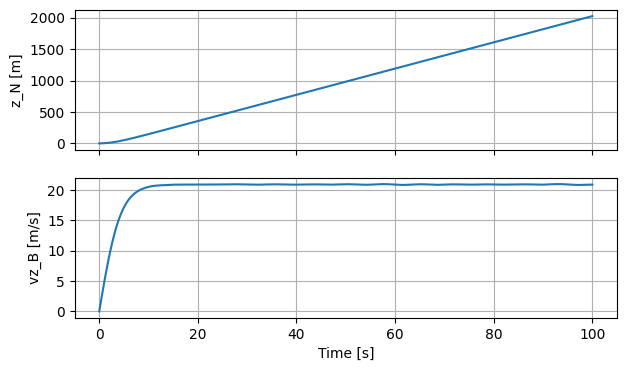

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True)
ax[0].plot(t_eval, xs.p_N[2], label='z')
ax[0].grid()
ax[0].set_ylabel('z_N [m]')
ax[1].plot(t_eval, xs.v_B[2], label='vz_B')
ax[1].grid()
ax[1].set_ylabel('vz_B [m/s]')
plt.xlabel('Time [s]')

As discussed, it's easy to run the exact same code with Archimedes by simply calling `arc.odeint` instead of `solve_ivp` from SciPy.
This will trigger construction of a symbolic "computational graph" defined by our model and then run the simulation with the SUNDIALS ODE solver.

In [5]:
xs_flat = arc.odeint(f, t_span, x0_flat, t_eval=t_eval)
xs_arc = vmap_unravel(xs_flat)

Text(0.5, 0, 'Time [s]')

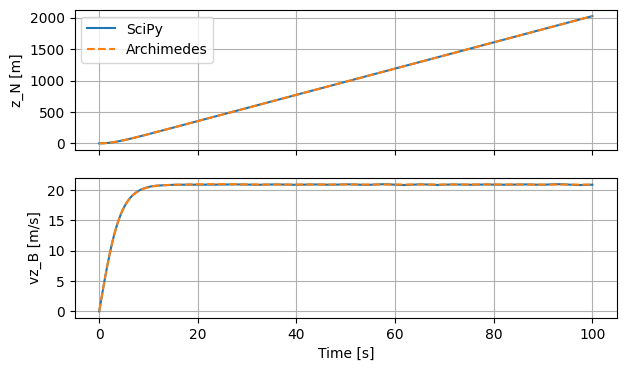

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True)
ax[0].plot(t_eval, xs.p_N[2], label='SciPy')
ax[0].plot(t_eval, xs_arc.p_N[2], '--', label="Archimedes")
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel('z_N [m]')
ax[1].plot(t_eval, xs.v_B[2])
ax[1].plot(t_eval, xs_arc.v_B[2], '--')
ax[1].grid()
ax[1].set_ylabel('vz_B [m/s]')
plt.xlabel('Time [s]')

In terms of simulation performance, a key difference here is that each time the dynamics function of the NumPy version gets evaluated, the code is executed in regular interpreted Python.
On the other hand, the Archimedes version will evaluate the exact same sequence of operations, but in pre-compiled C++, which can be considerably faster.

We can do a head-to-head comparison using the `%%timeit` magic in Jupyter, which will compare the _entire_ execution time of the simulation call, including the construction of the computational graph and any other setup and initialization.

In [7]:
%%timeit
solve_ivp(f, t_span, x0_flat, t_eval=t_eval)

46.5 ms ± 2.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%%timeit
ys = arc.odeint(f, t_span, x0_flat, t_eval=t_eval)

6.33 ms ± 273 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Here we see about a 5x speedup by running the exact same model with Archimedes instead of pure Python.
Of course, as noted above, it may be possible to improve the performance of the pure NumPy code by pre-allocating vectors or using vectorization wherever possible, although these optimizations tend to decrease readability and may make debugging more difficult.

In absolute terms, the difference between 15ms and 70ms to run a simulation is negligible from a practical point of view.
However, for more complex models this kind of acceleration can make a big difference in simulation throughput, especially when performing optimizations or "batch" simulation runs that vary initial conditions or model parameters.

## 4. Model analysis

Besides accelerating simulations, Archimedes also makes it easy to do more advanced analyses like identifying trim conditions and performing stability analysis.

#### Finding trim conditions for forward flight

For instance, a common task for flight vehicle analysis is identifying steady trim conditions.
For a quadrotor model like ours, we can set up a trim problem by defining a target translational velocity $\mathbf{v}_N$ (in the inertial frame) and angular velocity $\mathbf{\omega}_B$.
Nothing in our model depends on position, so we can arbitrarily set that to zero.
If we assume zero yaw angle, this leaves us six degrees of freedom: roll angle, pitch angle, and four rotor angular velocities.
The body-frame velocity is then derived from the inertial-frame velocity via the Euler-angle rotations matrix:

$$
\mathbf{v}_B =  ~^B\!\mathbf{C}^N \mathbf{v}_N
$$

For a steady operating point we want to require that the six acceleration quantities $\dot{\mathbf{v}}_B$ and $\dot{\mathbf{\omega}}_B$ in the state derivative vector are zero.
Putting it all together, we can define a residual function as follows:

In [9]:
# Target forward velocity in the inertial frame
v_N = np.array([10.0, 0.0, 0.0])

p_N = np.zeros(3)
w_B = np.zeros(3)

def residual(p):
    phi, theta = p[:2]  # (roll, pitch) angles
    u = p[2:]  # Rotor angular velocities
    rpy = np.array([phi, theta, 0.0], like=p)
    C_BN = multirotor.dcm(rpy)
    v_B = C_BN @ v_N  # Rotate velocity to the body frame
    x = vehicle.State(p_N, rpy, v_B, w_B)
    x_t = vehicle.dynamics(0.0, x, u)
    return np.hstack([x_t.v_B, x_t.w_B]) # Residuals of dynamics equations only

u0 = 2.0  # Initial guess for rotor angular velocity
# Initial guess for the parameter vector
p0 = np.array([0.0, 0.0, u0, u0, u0, u0])

residual(p0)

array([-1.103,  0.   ,  9.81 ,  0.   , -0.   ,  0.   ])


This gives us a nonlinear algebraic system with six equations in six unknowns, which can be efficiently solved using a Newton-Raphson method.
In Archimedes, this is accessible with the `root` function, which has a similar interface to `scipy.optimize.root` except that it uses (sparse) automatic differentiation to efficiently evaluate the Jacobian matrices.

In [10]:
p_trim = arc.root(residual, p0)

phi_trim = p_trim[0]
theta_trim = p_trim[1]
u_trim = p_trim[2:]

rpy_trim = np.array([phi_trim, theta_trim, 0.0])
C_BN = multirotor.dcm(rpy_trim)
v_B_trim = C_BN @ v_N

x_trim = vehicle.State(p_N, rpy_trim, v_B_trim, w_B)

print(f"roll: {np.rad2deg(phi_trim):.2f} deg")
print(f"pitch: {np.rad2deg(theta_trim):.2f} deg")
print(f"v_B: {v_B_trim}")
print(f"u: {u_trim}")

roll: 0.00 deg
pitch: -6.41 deg
v_B: [ 9.937  0.    -1.117]
u: [702.558 702.558 702.558 702.558]


Alternatively, the SciPy root-finding solver can still be employed directly, with the autodiff Jacobian constructed using the `arc.jac` function transformation, giving access to alternative algorithms like those in MINPACK:

In [11]:
sol = root(residual, p0, jac=arc.jac(residual), method='lm')

print(f"Roll: {np.rad2deg(sol.x[0]):.2f} deg")
print(f"Pitch: {np.rad2deg(sol.x[1]):.2f} deg")
print(f"u: {sol.x[2:]}")

Roll: 0.00 deg
Pitch: -6.41 deg
u: [702.558 702.558 702.558 702.558]


#### Linear stability analysis

In flight dynamics it is common to decouple the "longitudinal" from the "lateral-directional" degrees of freedom.
Broadly speaking, the longitudinal degrees of freedom relate to the body-frame $x-z$ plane:

* Pitch: $\theta$
* Surge: $v_B^x$
* Heave: $v_B^z$
* Pitch rate: $q$

The other states are assumed to be in their trim values.
We can analyze the stability of the longitudinal system by defining a function that maps from these degrees of freedom to their time derivatives, and then using `arc.jac` to compute the Jacobian matrices about the trim point.

In [12]:
def longitudinal_dofs(x):
    return np.hstack([
        x.att[1],  # theta
        x.v_B[0],  # vx
        x.v_B[2],  # vz
        x.w_B[1],  # q
    ])

x_lon_trim = longitudinal_dofs(x_trim)

# Right-hand side function for the longitudinal dynamics
def f_lon(x_lon, u):
    theta, vx, vz, q = x_lon  # Longitudinal degrees of freedom
    x = vehicle.State(
        np.zeros(3),
        np.hstack([phi_trim, theta, 0.0]),
        np.hstack([vx, v_B_trim[1], vz]),
        np.hstack([0.0, q, 0.0]),
    )
    x_t = vehicle.dynamics(0.0, x, u)
    return longitudinal_dofs(x_t)

# Linearized state-space matrices
A_lon = arc.jac(f_lon, 0)(x_lon_trim, u_trim)
B_lon = arc.jac(f_lon, 1)(x_lon_trim, u_trim)

print(f"A_lon:\n{A_lon}")
print(f"\nB_lon:\n{B_lon}")

A_lon:
[[ 0.     0.     0.     1.   ]
 [-9.749 -0.219  0.012  1.117]
 [ 1.096  0.012 -0.112  9.937]
 [ 0.     0.     0.     0.   ]]

B_lon:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [-0.007 -0.007 -0.007 -0.007]
 [ 0.199 -0.199 -0.199  0.199]]


This gives us a linearized state-space system in the form

$$
\dot{\mathbf{x}}_\mathrm{lon} = A_\mathrm{lon} \mathbf{x}_\mathrm{lon} + B_\mathrm{lon} u
$$

We can use this to analyze stability and system behavior in various ways.  For instance, assuming uniform changes to the rotor velocity, we can contruct a transfer function from input to heave velocity by defining the uniform $m \times 1$ control matrix

$$
\hat{B}_\mathrm{lon} = B_\mathrm{lon} \begin{bmatrix} 1 \\ 1 \\ 1 \\ 1 \end{bmatrix}
$$

and the output matrix

$$
\hat{C}_\mathrm{lon} = \begin{bmatrix} 0 & 0 & 1 & 0 \end{bmatrix},
$$

leading to the transfer function

$$
H(s) = \hat{C}_\mathrm{lon} \left(A_\mathrm{lon} - s I \right) \hat{B}_\mathrm{lon}.
$$

Alternatively, this can be analyzed easily by using the [Python Control Systems Library](https://python-control.readthedocs.io/):

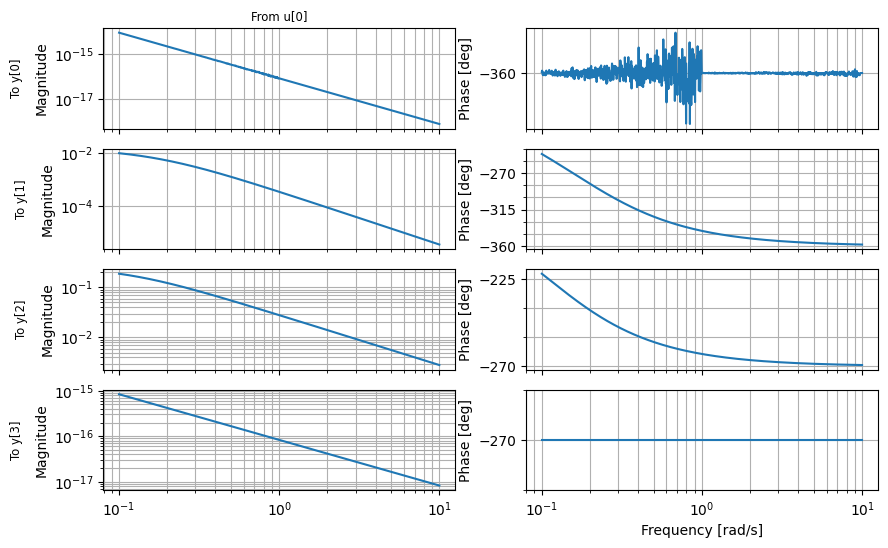

In [13]:
import control

C_hat = np.eye(4)
B_hat = B_lon @ np.ones((4, 1))
D_lon = np.zeros((C_hat.shape[0], 1))

lti_sys = control.StateSpace(A_lon, B_hat, C_hat, D_lon)
fig, ax = plt.subplots(4, 2, figsize=(10, 6), sharex=True)
control.bode_plot(lti_sys, ax=ax)
plt.show()

The lateral-directional dynamics include the remaining dynamical degrees of freedom relevant for perturbations to the trim condition:

* Roll: $\phi$
* Side-slip velocity: $v_B^y$
* Roll rate: $q$
* Yaw rate: $r$

In [14]:
def lateral_dofs(x):
    return np.hstack([
        x.att[0],  # phi
        x.v_B[1],  # vy
        x.w_B[0],  # p
        x.w_B[2],  # r
    ])
x_lat_trim = lateral_dofs(x_trim)

# Right-hand side function for the lateral-directional dynamics
def f_lat(x_lat, u):
    phi, vy, p, r = x_lat  # Perturbations
    x = vehicle.State(
        np.zeros(3),
        np.hstack([phi, theta_trim, 0.0]),
        np.hstack([v_B_trim[0], vy, v_B_trim[2]]),
        np.hstack([p, 0.0, r]),
    )
    x_t = vehicle.dynamics(0.0, x, u)
    return lateral_dofs(x_t)

# Linearized state-space matrices
A_lat = arc.jac(f_lat, 0)(x_lat_trim, u_trim)
B_lat = arc.jac(f_lat, 1)(x_lat_trim, u_trim)

print(f"A_lat:\n{A_lat}")
print(f"\nB_lat:\n{B_lat}")

A_lat:
[[ 0.     0.     1.    -0.112]
 [ 9.749 -0.11  -1.117 -9.937]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]]

B_lat:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [-0.199 -0.199  0.199  0.199]
 [ 0.006 -0.006  0.006 -0.006]]


## 5. Revisiting the rotor model (optional)

In this section we will extend and improve the rotor aerodynamics model, at this point likely the least accurate part of our multirotor model.
We will use the widely used blade element momentum theory (BEMT), in which we approximate the forces and moments as the integrals of contributions from 2D airfoil slices.
The new rotor aerodynamics model can be implemented in the same framework we have been using up to this point, enabling us to re-use all of our existing code and create highly configurable vehicle models.

A key step of the BEMT solver is the determination of an inflow parameter that is consistent with both the integrated 2D airfoil contributions and an overall momentum balance.
Typically this is accomplished with nested iterative solves, but we will see how the implicit function capabilities of Archimedes can make the implementation both simpler and more efficient.

#### Blade element theory

So far we have been using the quadratic model

$$
\begin{align*}
\mathbf{F}_{H_j}^j &= -k_F \Omega_j^2 \hat{\mathbf{z}} \\
\mathbf{M}_{H_j}^j &= k_M \Omega_j^2 \hat{\mathbf{z}},
\end{align*}
$$

where $\hat{\mathbf{z}}$ is a unit vector along the hub-frame $z$-axis and $H_j$ is the hub reference frame for the $j$-th rotor.
The problem with this model is that it does not account for the actual airflow across the rotor in any way.
For instance, if the vehicle is moving forward, the rotor can experience a significantly increased airflow on the advancing side and reduced airflow on the retreating side, which can have a pronounced effect on the generated forces and moments.

The basic idea of blade element theory is to consider a thin "slice" of the blade with infinitesimal thickness $dr$ as a 2D airfoil and calculate its contribution to the net force and moment produced by the rotor.
To facilitate this, we must introduce two new reference frames related to the rotor hub frame $H$.
We will drop the subscript $j$ since we are focusing on a single rotor for now; the `MultiRotorVehicle` class will still take care of summing the contributions from each of the rotors.

The new first reference frame is the "wind frame" W, defined so that the $x-y$ plane is still coincident with the rotor plane, but the incoming airflow is in the $x-z$ plane.
Specifically, if we ignore any true "wind" and assume the ambient air is still in the inertial reference frame, then the relative motion of the air with respect to the hub frame is the negative of the body-frame velocity, rotated into the hub frame:

$$
\mathbf{w}_H = - ~^H\!\mathbf{C}^B \mathbf{v}_B.
$$

Then the incident wind angle with respect to the hub-frame $x$-axis is

$$
\psi_w = \tan^{-1}(w_H^y / w_H^x)
$$

and the (time-varying) rotation matrix from the hub frame to the wind frame $~^W\!\mathbf{C}^H$ is defined by a right-handed rotation of $\psi_w$ about the hub-frame $z$-axis:

$$
~^W\!\mathbf{C}^H =
\begin{bmatrix}
\cos \psi_w & \sin \psi_w & 0 \\
-\sin \psi_w & \cos \psi_w & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

The final reference frame we will need is the "blade" frame.  If a single rotor blade is at azimuthal location $\psi$ (defined with respect to the negative wind-frame $x$-axis) and we consider a cross-sectional slice of the blade at radial location $r$, we can attach a reference frame $b$ at the point $(r, \psi)$, defined so that the $x$-axis is oriented opposite to the rotation of the blade and the $z$-axis is opposite to the wind-frame $z$-axis (i.e. up).
The new reference frames are illustrated in the following figure:

<img src="img/frames2.png" alt="reference_frames2" width="600"/>

In summary, to consider a single rotor blade we have five reference frames to contend with:

1. The Newtonian or inertial frame $N$
2. The body-fixed frame $B$, offset and oriented with respect to $N$ according to the state variables $\mathbf{p}_N$ and $\mathbf{\Phi}$.
3. The rotor hub frame $H$, offset and canted with respect to $B$ by fixed geometric parameters
4. The wind frame $W$, defined by a time-varying rotation about the hub-frame $z$-axis by $\psi_w$
5. The blade frame $b$, defined relative to the wind frame according to the polar coordinates $(r, \psi)$.

With these frames defined, we can calculate infinitesimal contributions to lift, drag, and moment due to the 2D airfoil section at $(r, \psi)$ in the blade frame.
In general the dimensionless sectional aerodynamic coefficients $C_L$, $C_D$, and $C_M$ are taken to be functions of angle of attack $\alpha$, Reynolds number, and Mach number, although the dependence on Reynolds and Mach number is often treated with empirical corrections or neglected.
The aerodynamic coefficients can be looked up in tabulated experimental or CFD data, or approximated with an analytic form like thin airfoil theory.

The angle of attack is a function of both the fixed blade pitch $\theta_b$, which typically varies along the span of the blade and the "inflow angle" $\gamma$, corresponding to the "flight path angle" used in fixed-wing flight dynamics.
The inflow angle is the inclination with respect to the blade-frame $x$-axis of the blade-relative airflow $\mathbf{u}_b$, which is _not the same_ as the blade-frame wind vector $\mathbf{w}_b$.
If the instantaneous rotor angular velocity is $\Omega$, the blade-relative airflow is calculated as follows:

$$
\begin{align*}
u_b^x &= w_b^x \sin \psi - r \omega_b^z + \Omega r \\
u_b^z &= -w_b^z  + r \omega_b^y - \lambda \Omega R,
\end{align*}
$$

where $\mathbf{\omega}_b$ is the blade-frame angular velocity of the vehicle and $\lambda$ is a dimensionless "inflow ratio" that accounts for the induced vertical velocity required by conservation of momentum when the rotor is producing thrust.
Generally $\lambda$ will depend on the translational and angular velocity of the vehicle, the location $(r, \psi)$ of the blade element, and the instantaneous state of the wake if this is taken into account.
The determination of $\lambda$ is the most difficult aspect of blade element theory; we will return to this shortly.

Once the blade-relative airflow is computed, the inflow angle is given by

$$
\gamma = \tan^{-1} (-u_b^z/u_b^x)
$$

and the angle of attack is simply

$$
\alpha = \theta_b(r) - \gamma.
$$

This value is then used in conjunction with the local Reynolds and Mach numbers to determine the lift, drag, and moment coefficients $C_L$, $C_D$, and $C_M$.
The infinitesimal contributions to lift, drag, and moment from this 2D blade section with are

$$
\begin{align*}
dL &= \frac{1}{2} \rho c U_\infty^2 C_L ~ dr \\
dD &= \frac{1}{2} \rho c U_\infty^2 C_D ~ dr \\
dM &= \frac{1}{2} \rho c^2 U_\infty^2 C_M,
\end{align*}
$$

where $U_\infty^2 = ||\mathbf{u}_b||^2$ is the freestream velocity, $\rho$ is the air density, and $c$ is the local blade chord (which may also vary as a function of radial location $r$).

By definition, the drag is in the direction of the inflow $\mathbf{u}_b$ and the lift is perpendicular to it.
These must be rotated about the blade-frame $y$-axis by the inflow angle $\gamma$ to retrieve the infinitesimal blade-frame forces:

$$
d\mathbf{F}_b
=
\begin{bmatrix}
\cos \gamma & 0 & -\sin \gamma\\
0 & 1 & 0 \\
\sin \gamma & 0 & \cos \gamma
\end{bmatrix}
\begin{bmatrix}
dL \\ 0 \\ dD
\end{bmatrix}.
$$

Here the "blade frame" is no longer well-defined since we have removed the radial position, so this force should be taken as located at the blade root with orientation still consistent with the azimuthal coordinate $\psi$.
The net force and moment due to a rotor blade at azimuthal location $\psi$ can then be calculated by integrating over the blade span:

$$
\begin{align*}
\mathbf{F}_b(\psi) &= \int d\mathbf{F}_b \\
\mathbf{M}_b(\psi) &= \int \hat{\mathbf{y}} dM + \int r\hat{\mathbf{y}} \times d\mathbf{F}_b.
\end{align*}
$$

These forces can be rotated into consistent wind frame forces and moments $\mathbf{F}_W(\psi)$ and $\mathbf{M}_W(\psi)$ with the rotation matrix $~^W\!\mathbf{C}^b$, which is constant along the blade span.

Finally, since the rotors are typically spinning much faster than any relevant vehicle dynamics, it is common to average these forces over one rotation of the rotor blade, and scale the result by the number of rotor blades $N_b$:

$$
\begin{align*}
\overline{\mathbf{F}}_W(\psi) &= \frac{N_b}{2 \pi} \int_0^{2\pi} \mathbf{F}_W(\psi) ~ d \psi \\
\overline{\mathbf{M}}_W(\psi) &= \frac{N_b}{2 \pi} \int_0^{2\pi} \mathbf{M}_W(\psi) ~ d \psi.
\end{align*}
$$

If the rotor is spinning clockwise, then the same analysis applies but the sign is reversed on $\overline{F}_W^y$, $\overline{M}_W^x$, and $\overline{M}_W^z$.

Numerically, these integrals can be evaluated with Gaussian quadrature; the radial and azimuthal nodes are determined ahead of time and the infinitesimal forces can be evaluated at each $(r, \psi)$ node location, then summed with the quadrature weights to approximate the integral.

#### Uniform inflow approximation: momentum theory

We now return to the final ingredient in the blade element theory: the inflow ratio $\lambda$.
While there are a number of models to choose from that treat the wake with varying degrees of fidelity, perhaps the simplest is momentum theory.
The basic premise of momentum theory is Newton's third law: every action has an equal and opposite reaction.
More precisely for present purposes, if the rotor is imparting thrust (a change in momentum over time) to the vehicle, the momentum of the surrounding air must also be increased by the same amount.

The basic approximation of momentum theory is that the inflow ratio $\lambda$ is constant across the rotor disk.
In the case of steady hover or forward flight a basic momentum balance calculation can be carried out (see for instance the reference text by Leishman) for any value of $\lambda$ to determine a corresponding thrust coefficient $C_T^\mathrm{mom}$.
Defining $\mu_x = w_W^x / \Omega R$ and $\mu_z = w_W^z / \Omega R$ as the relative velocities nondimensionalized by tip speed $\Omega R$, momentum balance predicts a thrust coefficient

$$
C_T^\mathrm{mom}(\lambda) = 2(\lambda - \mu_z) \sqrt{\mu_x^2 - \lambda^2}.
$$

On the other hand, for the same value of $\lambda$ the blade element method independently determines a value of the thrust coefficient by nondimensionalizing the predicted $z$-component of wind-frame force:

$$
\overline{F}_W^z(\lambda) = \rho A \left(\Omega R\right)^2 C_T^\mathrm{bem},
$$

where $A = \pi R^2$ is the rotor disk area.

If we require that $\lambda$ must have a value such that $C_T^\mathrm{mom}$ and $C_T^\mathrm{bem}$ are consistent for the instantaneous velocity (i.e. assuming the vehicle were to be in steady level flight at that velocity), this gives us two equations in two unknowns.  In other words, by requiring that $C_T^\mathrm{mom} = C_T^\mathrm{bem}$, we have a single equation that implicitly defines $\lambda$:

$$
2(\lambda - \mu_z) \sqrt{\mu_x^2 - \lambda^2} = \frac{\overline{F}_W^z(\lambda)}{\rho \pi \Omega^2 R^4}.
$$

Specifically, given the vehicle state $\mathbf{x}$ and the rotor velocity $\Omega$, we can define a "residual" function that should be zero when the value of $\lambda$ is consistent with both the blade element method and momentum balance:

$$
F(\lambda, \mathbf{x}, \Omega) = C_T^\mathrm{mom} - C_T^\mathrm{bem} = 0.
$$

This can be viewed as an implicit function $\lambda = f(\mathbf{x}, \Omega)$, where we cannot write a closed-form expression for $f$.
In principle, a single root solve using for instance the Newton-Raphson method could be used to find the zero of the function $F$ for given $\mathbf{x}$ and $\Omega$, thereby determining $\lambda$.
However, this would require being able to efficiently compute the Jacobians $\partial F/ \partial \lambda$, $\partial F / \partial \mathbf{x}$, and $\partial F / \partial \Omega$, which requires differentiating through both the momentum balance equation (which is straightforward) and the blade element thrust calculation (which is not).

As a result, in practice an appropriate value of $\lambda$ is typically determined with nested iterative solvers.
First, for a candidate value of the thrust coefficient $C_T^\mathrm{mom}$ and the current values of $\mu_x$ and $\mu_z$, the Newton-Raphson method is used to solve for the corresponding value $\lambda$ required by momentum balance.
This value of $\lambda$ is then used for the thrust calculation in the blade element method, which in general will result in a _different_ value of the thrust coefficient, i.e. $C_T^\mathrm{bem} \neq C_T^\mathrm{mom}$.
Some combination of the new and old values of the thrust coefficient are then used for the next iteration of the Newton-Raphson solver.

Archimedes can significantly simplify this process with its implicit function capabilities, which combine automatic differentiation with root solving to easily and efficiently solve this kind of equation.
If we have a function like $F(x, z) = 0$ which we want to use as an implicit function $x = f(z)$ without writing $f$, in Archimedes we can simply do the following:

```python
def F(x, z):
    # ... compute and return residual
    
f = arc.implicit(F)
x = f(z)  # Find x such that F(x, z) = 0
```

The `implicit` function creates and returns a new function with the first argument removed (in this case `x`).
Under the hood, this function calls a Newton solver and uses CasADi's powerful automatic differentiation capabilities to evaluate the required Jacobians.

For the induced inflow ratio calculation, the implementation will look something like the following, where `v_W` is the wind-frame vehicle translational velocity $\mathbf{v}_W$ and `w_W` is the wind-frame vehicle angular velocity $\mathbf{\omega}_W$:

```python
def CT_residual(lambda_, v_W, w_W, Omega):
    mu_x = -v_W[0] / (Omega * R)
    mu_z = -v_W[2] / (Omega * R)
    CT_mom = 2 * (lambda_ - mu_z) * np.sqrt(mu_x ** 2 + lambda_ ** 2)
    CT_bem = calc_thrust(v_W, w_W, Omega, lambda_)
    return CT_mom - CT_bem

inflow_ratio = arc.implicit(CT_residual)
lambda_ = inflow_ratio(v_W, w_W, Omega)
```

This value of $\lambda$ is then used for the full blade-element calculation; the combination of this uniform inflow based on momentum balance with the blade-element method is called blade element momentum theory (BEMT).
If used with proper airfoil data it can be a fairly accurate approximation for steady flight, although the assumptions required by the momentum theory become fairly limiting for more aggressive maneuvers.

#### Implementation

The blade element model fits neatly into the class structure we've already defined above, as a new implementation of the `RotorModel` interface.
We just need to implement the `wind_frame_loads` method, which computes the wind-frame loads $\mathbf{F}_W$ and $\mathbf{M}_W$ given the wind-frame vehicle translational and angular velocities $\mathbf{v}_W$ and $\mathbf{\omega}_W$, rotor speed $\Omega$, and the `RotorGeometry` struct.
The actual implementation of this class is relatively involved, though it closely follows the preceding math; see the source code in `multirotor.py` for details.
Although the `BladeElementModel` implements the BEMT method described above, it is also written to be extensible for variable inflow ratio models or "dynamic inflow" models that have auxiliary state variables.

One new addition to the classes in our framework is an `AirfoilModel` used to compute the aerodynamic coefficients $C_L$, $C_D$, $C_M$ for a 2D "blade element" as a function of angle of attack, Reynolds number, and freestream Mach number:

```python
class AirfoilModel(metaclass=abc.ABCMeta):
    """Model for aerodynamics of a 2D subsonic airfoil section."""

    compressibility_model: str = None

    @abc.abstractmethod
    def __call__(self, alpha, Re, M_inf):
        """Returns lift, drag, and moment coefficients for the given angle of attack
        
        Args:
            alpha: angle of attack [rad]
            Re: Reynolds number
            M_inf: freestream Mach number
        
        Returns:
            Cl: lift coefficient
            Cd: drag coefficient
            Cm: quarter-chord moment coefficient
        """
```

As with gravity, vehicle drag, and the rotor aerodynamics, creating a well-defined interface allows us to create very different models that are compatible with the rest of the framework.
For instance, the tutorial module `multirotor.py` contains a simple `ThinAirfoil` class that will compute coefficients consistent with ideal-fluid aerodynamics solutions for thin airfoils with small angle of attack.
It also implements a `TabulatedAirfoil` class which uses lookup tables to estimate the aerodynamic coefficients based on experimental or CFD data.
As a more computationally intensive example, a vortex panel code similar to XFOIL could also be implemented in the same interface and used in conjunction with automatic differentiation for design optimization.

<img src="img/class_hierarchy2.png" alt="class_hierarchy2" width="600"/>

#### Running the blade element model

Because the BEMT rotor model simply extends the existing framework, we can create the model just as we did with the quadratic rotor model except with the additional initialization required for the BEMT model.

This example uses the `TabulatedAirfoil` model with lookup tables derived from the open-source CFD code [SU2](https://su2code.github.io/) using the NACA 0012 profile.
As a word of caution, typical rotor blades have significant camber, so this data is likely not representative of any particular rotor blade aerodynamics.
It should be used for illustrative purposes only.

Using the NACA 0012 data, we will initialize the blade element model using a linearly twisted blade from $20^\circ$ at the root to $10^\circ$ at the tip.  The chord length also varies linearly from 30 mm at the root to 10 mm at the tip.

In [15]:
# Inertia matrix of a cylinder with mass m, radius r, and height h
m = 2.0
g0 = 9.81
R = 0.15  # Rotor radius (also boom length)
H = 0.15  # Body height
J_B = np.array([
    [m/12*(3*R**2 + H**2), 0, 0],
    [0, m/12*(3*R**2 + H**2), 0],
    [0, 0, m/2*R**2],
])
L = 0.30  # Rotor arm length

# Four rotors mounted at 45, 135, 225, and 315 degrees
# No canting and alternating spin directions
rotors = []
theta = np.pi/4
ccw = True
for i in range(4):
    rotors.append(multirotor.RotorGeometry(
        offset=np.array([L*np.cos(theta), L*np.sin(theta), 0]),
        ccw=ccw,
    ))
    theta += np.pi/2
    ccw = not ccw

drag_model = multirotor.QuadraticDragModel(
    rho=1.225,
    Cd=1.6,
    A=R*H,
)

gravity_model = multirotor.ConstantGravityModel(g0=g0)

c0 = 0.03  # Root chord
th0 = np.deg2rad(20.0)  # Root pitch
ct = 0.01  # Tip chord
tht = np.deg2rad(-10.0)  # Twist per unit length
e = 0.1  # Root cut-out ratio

def chord(r_):
    r_bar = r_ / R
    return (c0 * (1 - r_bar) + ct * (r_bar - e)) / (1 - e)

def pitch(r_):
    r_bar = r_ / R
    return th0 + tht * (r_bar - e) / (1 - e)

airfoil_model = multirotor.TabulatedAirfoil(
    airfoil_data=[multirotor.NACA_0012, multirotor.NACA_0012],
    rad_loc=[e*R, R],
)

T0 = m * g0 / len(rotors)  # Initial guess for trim thrust
rotor_model = multirotor.BladeElementModel(
    R=R,
    e=e,
    T0=T0,
    airfoil_model=airfoil_model,
    chord=chord,
    blade_pitch=pitch,
)

vehicle = multirotor.MultiRotorVehicle(
    m=m,
    J_B=J_B,
    rotors=rotors,
    drag_model=drag_model,
    rotor_model=rotor_model,
    gravity_model=gravity_model,
    attitude="euler",
)


As before, we will use a constant angular velocity close to hover.
The only difference now has to do with the use of the lookup tables.
The symbolic interpolant used behind the scenes by CasADi is not compatible with the default scalar ("SX") symbolic type and requires the matrix ("MX") symbolic type.
Hence, we have to explicitly create an "MX" symbolic function before calling the `odeint` function:

Text(0.5, 0, 'Time [s]')

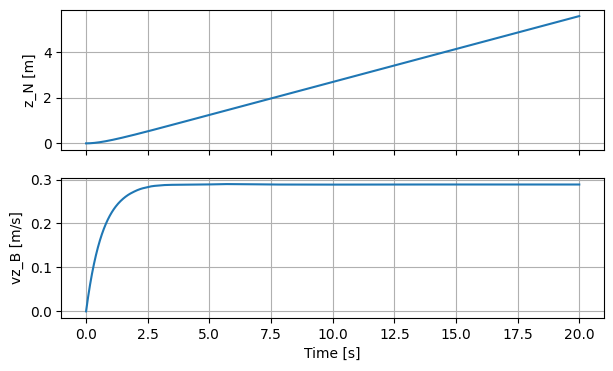

In [16]:
u0 = 500.0 * np.ones(4)  # Rotor angular velocity (rad/s)

t0 = 0.0
t1 = 20.0


# Initial state for simulation
x0 = vehicle.State(
    p_N=np.zeros(3),  # Initial position [m]
    att=np.zeros(3),  # Initial roll-pitch-yaw [rad]
    v_B=np.zeros(3),  # Initial velocity [m/s]
    w_B=np.zeros(3),  # Initial angular velocity [rad/s]
)
x0_flat, unravel = arc.tree.ravel(x0)

# vmap_unravel will convert a flat solution (x, t) to a vehicle.State
vmap_unravel = arc.vmap(unravel, in_axes=1, out_axes=1)

# Wrap the vehicle dynamics model in a function with
# the signature `xdot = f(t, x)`
@arc.compile
def f(t, x_flat):
    x = unravel(x_flat)
    x_t = vehicle.dynamics(t, x, u0)
    return arc.tree.ravel(x_t)[0]  # Return only the flattened state


t_span = (t0, t1)
t_eval = np.linspace(*t_span, 1000)
xs_flat = arc.odeint(f, t_span, x0_flat, t_eval=t_eval)
xs = vmap_unravel(xs_flat)  # Return to vehicle.State format

fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True)
ax[0].plot(t_eval, xs.p_N[2])
ax[0].grid()
ax[0].set_ylabel('z_N [m]')
ax[1].plot(t_eval, xs.v_B[2])
ax[1].grid()
ax[1].set_ylabel('vz_B [m/s]')
plt.xlabel('Time [s]')

The same idea about "MX" symbolics apply to identifying a trim point and performing linear stability analysis.
As a general rule, it's safe to use the default "MX" symbolics - if you want to try improving performance you can experiment with creating "SX" functions, provided they don't contain unsupported operations like root-finding or interpolation.

In [17]:
# Trim point identification

v_N = np.array([10.0, 0.0, 0.0]) # Target forward velocity in the inertial frame
p_N = np.zeros(3)  # Arbitrary position
w_B = np.zeros(3)  # Target angular velocity in the body frame

@arc.compile
def residual(p):
    phi, theta = p[:2]  # (pitch, roll) angles
    u = p[2:]  # Rotor angular velocities
    rpy = np.array([phi, theta, 0.0], like=p)
    C_BN = multirotor.dcm(rpy)
    v_B = C_BN @ v_N
    x = vehicle.State(p_N, rpy, v_B, w_B)
    x_t = vehicle.dynamics(0.0, x, u)
    return np.hstack([x_t.v_B, x_t.w_B])  # Residuals of dynamics equations only

u0 = 500.0
p0 = np.array([0.0, 0.0, u0, u0, u0, u0])

p_trim = arc.root(residual, p0)

phi_trim = p_trim[0]
theta_trim = p_trim[1]
u_trim = p_trim[2:]

rpy_trim = np.array([phi_trim, theta_trim, 0.0])
C_BN = multirotor.dcm(rpy_trim)
v_B_trim = C_BN @ v_N

x_trim = vehicle.State(p_N, rpy_trim, v_B_trim, w_B)

print(f"roll: {np.rad2deg(phi_trim):.2f} deg")
print(f"pitch: {np.rad2deg(theta_trim):.2f} deg")
print(f"v_B: {v_B_trim}")
print(f"u: {u_trim}")

roll: -0.00 deg
pitch: -8.83 deg
v_B: [ 9.881  0.    -1.535]
u: [512.53  512.517 512.517 512.53 ]


In [18]:
# Longitudinal dynamics include surge (vx), heave (vz), pitch (theta), and pitch rate (q)
# The other states are assumed to be in trim


# Right-hand side function for the longitudinal dynamics
def f_lon(x_lon, u):
    theta, vx, vz, q = x_lon  # Longitudinal degrees of freedom
    x = vehicle.State(
        np.zeros(3),
        np.hstack([phi_trim, theta, 0.0]),
        np.hstack([vx, v_B_trim[1], vz]),
        np.hstack([0.0, q, 0.0]),
    )
    x_t = vehicle.dynamics(0.0, x, u)
    return longitudinal_dofs(x_t)

x_lon_trim = longitudinal_dofs(x_trim)

# Linearized state-space matrices
A_lon = arc.jac(f_lon, 0)(x_lon_trim, u_trim)
B_lon = arc.jac(f_lon, 1)(x_lon_trim, u_trim)

print(f"A_lon:\n{A_lon}")
print(f"\nB_lon:\n{B_lon}")

A_lon:
[[ 0.     0.     0.     1.   ]
 [-9.694 -0.259  0.03   1.535]
 [ 1.506 -0.288 -2.135  9.882]
 [ 0.    -0.004  0.011 -0.958]]

B_lon:
[[ 0.     0.     0.     0.   ]
 [-0.    -0.    -0.    -0.   ]
 [-0.01  -0.01  -0.01  -0.01 ]
 [ 0.274 -0.273 -0.273  0.274]]


As a result of the much richer aerodynamics model, the longitudinal dynamics are more strongly coupled, as seen in the more interesting behavior of the transfer functions between a uniform input to all four rotors and the longitudinal state variables:

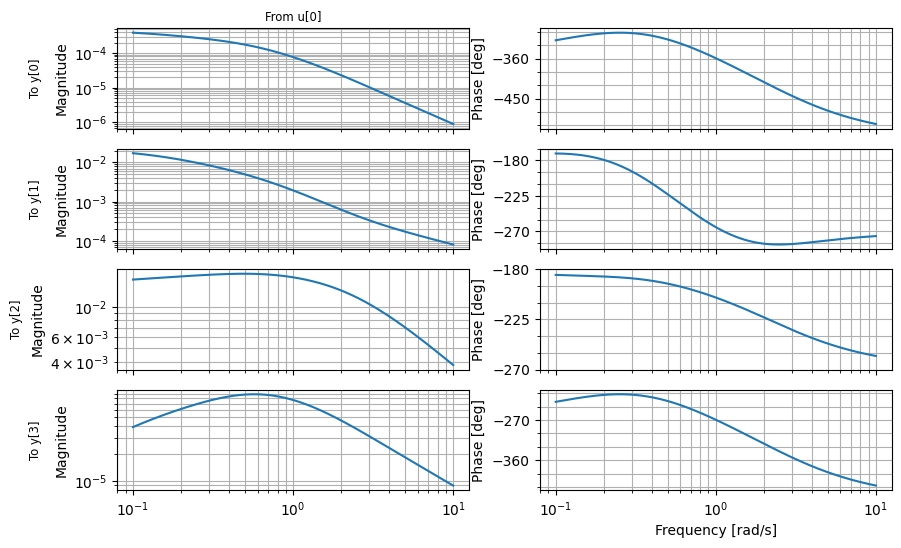

In [19]:
C_hat = np.eye(4)
B_hat = B_lon @ np.ones((4, 1))
D_lon = np.zeros((C_hat.shape[0], 1))

lti_sys = control.StateSpace(A_lon, B_hat, C_hat, D_lon)
fig, ax = plt.subplots(4, 2, figsize=(10, 6), sharex=True)
control.bode_plot(lti_sys, ax=ax)
plt.show()

## 6. Conclusion

In this tutorial, we've explored the capabilities of Archimedes through the lens of multirotor flight vehicle modeling. We've demonstrated how Archimedes can handle complex computational graphs efficiently, provided a proof-of-concept implementation for multirotor dynamics, and laid the groundwork for more advanced modeling and analysis techniques.

We covered the basics of multirotor flight vehicle modeling, including 6-dof rigid body dynamics and blade-element momentum theory for rotor aerodynamics. While the details of this model are fairly specific to this kind of flight vehicle, it represents a moderately complex physics model common in aerospace engineering applications.

Key points from this tutorial include:

* A straightforward implementation of the model equations in NumPy easily ran with Archimedes, yielding a ~5x speedup in simulation.
* Archimedes also enabled automatic differentiation for trim point identification and linear stability analysis, again with the same NumPy code
* We saw the power and simplicity of the implicit function abstraction in Archimedes when implementing the momentum theory inflow model.

Beyond illustrating multirotor flight vehicle modeling, this code (or a similar framework) can be the starting point for more advanced analysis and applications, such as:

* Trajectory optimization to design optimal flight paths and control sequences
* Parameter estimation for calibrating model parameters against test data
* Advanced aerodynamics modeling like dynamic inflow or vortex particle methods
* Design optimization with an XFOIL-type panel code to solve sectional aerodynamics for variable airfoil profiles
* State estimation (IMU) algorithms and discrete control system design with automatic C code generation for hardware deployment

We also discussed the design of a modular and extensible modeling framework, combining a hierarchy of classes (inheritance) with nested callable classes that implement well-defined abstract interfaces (composition). By thoughtfully structuring the framework, we were able to add a significantly more complex component model (the blade-element model) while fully reusing our existing code. Similar principles can be applied to a wide range of physics models.

With careful development and application of these modeling principles, Archimedes provides a powerful tool for aerospace engineering and beyond. We encourage you to explore Archimedes further:

1. Visit our GitHub repository [link]() to access the full codebase and documentation
2. Join our community forum [link]() to discuss your projects and get help from other users
3. Stay tuned for upcoming tutorials on trajectory optimization, parameter estimation, and more